# Section 0 - Import Tools

## 0.1. Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# import for auto-suggestions for objects
import pydot
import pyreadline
# import for sigmoid-fct.
import scipy
import scipy.special
from scipy import stats
from scipy.stats import gamma, truncnorm, describe
import sklearn
from sklearn import preprocessing, cluster
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
# import for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import decimal
import json # to save history objects of keras models
import pickle # to save general objects, e.g. K-Means Clustering Object
import os

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras import layers
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD, Adadelta
from keras.layers import Dense, Flatten, Dropout, multiply, dot, Activation, ThresholdedReLU, RepeatVector, subtract, Reshape
from keras.layers import RNN, SimpleRNN,GRU, LSTM,CuDNNLSTM, Reshape, Lambda, InputLayer, Input, BatchNormalization, Average, average
from keras.layers import advanced_activations as adv_act
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import plot_model, print_summary
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import seaborn as sb
import sobol_seq

Using TensorFlow backend.


## 0.2. Import customized functions

In [4]:
# Functions
%run functions/actuarial_functions.ipynb
%run functions/rnn_functions.ipynb
%run functions/visualization_functions.ipynb
%run functions/statistical_analysis_functions.ipynb
%run functions/clustering.ipynb

In [5]:
# Simulation of Data&Targets
%run Data/data_part1_simulation_feature_space.ipynb
%run Data/data_part2_calculation_targets.ipynb

In [6]:
# Data Preparation
%run Data/data_prep_General.ipynb
%run Data/data_prep_RNN_data_transformation.ipynb

In [7]:
# Single-dimensional data analysis
%run data_analysis_single_dimension/models_1dim_FFN.ipynb

# Section 1 - Global Parameters

In [141]:
# Makeham mortality model
A= 0.00022
B=2.7*10**(-6)
c=1.124
int_rate = 0.05 # fixed for now
#age_max = 131
# Portfolio Details
N_contracts = 100000 # adjustable
input_used = ['age_start', 'Sum_ins', 'duration', 'age_of_contract']
n_in = len(input_used)

# Standard values of features for projections
age_std = 40
sum_std = 100000
dur_std = 20
aoc_std = 0

Max_min = np.zeros([n_in,2])
age_low, age_up = 25, 67
sum_min, sum_max = 1000, 1000000
dur_min, dur_max = 2, 40
aoc_min, aoc_max = 0, dur_max-1

# zero-padded output/ length of later targets
n_output = dur_max +1

# Matrix Version of previous upper/ lower bounds on features
Max_min = np.array([age_low,age_up+dur_max,sum_min, sum_max, dur_min, dur_max, aoc_min, aoc_max], dtype = 'int').reshape(n_in,2)

# Split ration training and test data
ratio_tr_tst = 0.7
N_train = int(ratio_tr_tst*N_contracts)

# share of validation data
val_share = 0.25

# Default value for RNN-data replication
matured_default_value = -5

# current directory for saving issues
wd_sensis = r"C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code\checkpoints\Sensitivities"
# dummy if saved models should be loaded (TRUE) or the all models should be recalculated
dummy_load_saved_models = True

# Dataframe representation
pd.set_option('precision', 2)

In [142]:
# Sensitivity Analysis for following values
interest_rate_lst = [0.005,0.02]
A_lst = [0.0001, 0.02]
B_lst = [2.7*10**(-5),2.7*10**(-6),2.7*10**(-8)]
c_lst = [1.1, 1.24, 1.2]

sensi_lst = [[0.02,0.00022,2.7*10**(-6),1.124],[0.005,0.00022,2.7*10**(-6),1.124],
             [0.05,0.02,2.7*10**(-8),1.2], [0.05,0.02,2.7*10**(-5),1.1]]

In [143]:
table_sensi = pd.DataFrame(data = None, index = None, columns=['i', 'A','B','c'])
for i in range(len(sensi_lst)):
    table_sensi.loc['Scenario {}'.format(i+1)]=sensi_lst[i]
    
table_sensi

,i,A,B,c
Scenario 1,2.00e-02,2.20e-04,2.70e-06,1.12
Scenario 2,5.00e-03,2.20e-04,2.70e-06,1.12
Scenario 3,5.00e-02,2.00e-02,2.70e-08,1.20
Scenario 4,5.00e-02,2.00e-02,2.70e-05,1.10


In [144]:
#for i in interest_rate_lst:
#    int_rate = i
#    for a in A_lst:
#        A=a
#        for t in range(3):
#            B,c = B_lst[t], c_lst[t]

for k in range(len(sensi_lst)):
    int_rate = sensi_lst[k][0]
    A = sensi_lst[k][1]
    B = sensi_lst[k][2]
    c = sensi_lst[k][3]

    # Section 2 - Data

    ## 2.1. Simulation of feature variables

    random.seed(42)
    data_part1 = data_simulation_features(A, B, c, N_contracts, Max_min)

    # data for full dimension
    data = data_part1[0]

    ## 2.2. Calculation of Target Values

    # Create Targets
    targets = np.zeros([N_contracts,dur_max +1] )

    for i in range(N_contracts):
    # Targets of full dimensional feature space
        targets[i,0:max(data[i,2]-data[i,3]+1,0)] = get_termlife_reserve_profile(age_curr = data[i,0], 
                                                             Sum_ins = data[i,1],duration= data[i,2],  
                                                             interest = int_rate, 
                                                             age_of_contract = data[i,3], 
                                                             option_past=False, A=A,B=B,c=c)


    ## 2.3. Data Preparation

    ### 2.3.1. Scaling

    ## Parameters for scaling procedure of targets
    V_max = get_termlife_reserve_profile(age_curr=age_up, Sum_ins = sum_max, duration=dur_max, 
                                                interest = int_rate).max()
    V_min = get_termlife_reserve_profile(age_curr=age_low, Sum_ins = sum_min, duration=dur_min, 
                                         interest = int_rate).min()
    data_sc = data_prep_feautures_scale(data, Max_min, option = 'conditional', option_1dim = False)
    data_train_sc, data_test_sc = data_prep_split(data_sc, ratio_tr_tst)

    ### 2.3.2. Split (raw and scaled) Data in Training and Test Set

    targets_train, targets_test= data_prep_split(targets,ratio_tr_tst)


    # Transform data to plain, 3-dim input without default value

    data_plain_sc = data_full_transform_test(data = data_sc, n_aim = n_output, input_type= 'plain')
    data_plain_train_sc = data_full_transform_test(data = data_train_sc, n_aim = n_output, 
                                                   input_type= 'plain')
    data_plain_test_sc = data_full_transform_test(data = data_test_sc, n_aim = n_output, 
                                                  input_type= 'plain')

    # save data
    cache = [[data_plain_train_sc, data_plain_test_sc], [targets_train,targets_test], 
             [int_rate,A,B,c], [V_min,V_max]]
    with open(wd_sensis+r'\setting_{}'.format(k)+r'\data_int={}_A={}_B={}_c={}.pkl'.format(int_rate,A,B,c),
              'wb') as output:
        pickle.dump(cache, output, pickle.HIGHEST_PROTOCOL)



# Section 3: Reserve Replication, Single Contract Basis

## 3.3. Ensemble Method for Quantitative Models

### Model Input: 'Plain'

In [148]:
N_epochs_ensemble = 300
n_timesteps, n_features, n_output = dur_max+1,n_in, dur_max+1
INPUT = Input(shape=(n_timesteps,n_features), name = 'Input')
dummy_load_saved_models_ensembles=True
N_ensembles = 5

In [187]:
#count = 0
#for i in interest_rate_lst:
#    int_rate = i
#    for a in A_lst:
#        A=a
#        for t in range(len(B_lst)):
#            B,c = B_lst[t], c_lst[t]

for k in range(len(sensi_lst)):
    int_rate = sensi_lst[k][0]
    A = sensi_lst[k][1]
    B = sensi_lst[k][2]
    c = sensi_lst[k][3]

    optimal_weights_loaded = False
    
    # import file
    with open(wd_sensis + r'\setting_{}\data_int={}_A={}_B={}_c={}.pkl'.format(k,int_rate,A,B,c), 'rb') as input:
        cache = pickle.load(input)
    
    # extract data
    data_plain_train_sc, data_plain_test_sc = cache[0][0], cache[0][1]
    targets_train, targets_test = cache[1][0], cache[1][1]
    V_max = cache[3][1]

    # Create Multiple RNNs with identical configuration
    models_sensi = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,
                                              nodes= [n_output], 
                                        n_output=n_output, final_dense_layer = True, 
                                              dense_act_fct= 'tanh',
                                        optimizer_type='adam',
                                        loss_type='mse', metric_type='mae', dropout_option=False, 
                                        dropout_share=[0.2,0.2], lambda_layer = True, 
                                              lambda_scale =V_max, 
                                        log_scale=True)

    # Either load existing parameters
    if os.path.isfile(wd_sensis+r'\setting_{}\model_0.h5'.format(k))&dummy_load_saved_models_ensembles:
        # load model weights
        for l in range(N_ensembles):
            models_sensi[l].load_weights(wd_sensis+r'\setting_{}\model_{}.h5'.format(k,l))
        optimal_weights_loaded = True

    # Or train model    
    else:
        models_sensi, hist_sensi = train_individual_ensembles(models_sensi, data_plain_train_sc, 
                                                              targets_train, 
                                                    n_epochs= N_epochs_ensemble, 
                                                    path =wd_sensis +r'\setting_{}'.format(k))
        # Save Model (and History) is integrated in function 'train_individual_ensembles'

    # Unless optimal weights have been imported a statistical analysis in meaningless
    if optimal_weights_loaded == True: 
        print(k)
        # combine models to a single model using an ensemble approach (no qualitative Model included)
        ensemble_sensi = combine_models(input_layer=INPUT, n_ensembles= len(models_sensi), 
                                              load_weights= True, 
                                        weights_ensembles = multiple_models_get_weights(models_sensi), 
                                              scale = V_max,
                                       LSTM_nodes= [n_output], dense_act_fct= 'tanh')



        #Statistics, using $e_t$

        # Relate following relative values to absolute Policy Values
        interval_lst = [0,0.001, 0.005, 0.01,0.2,0.4,0.6,0.8,0.9,1]
        PV_interval =  V_max*np.asarray([0.001, 0.005, 0.01,0.2,0.4,0.6,0.8,0.9,1])
        df_columns = [None]*(len(interval_lst)-1)
        for i in range(1,len(interval_lst)):
            df_columns[i-1] = '{}'.format(interval_lst[i])
        df = pd.DataFrame(data = None, index = None, columns = df_columns)
        df.loc['PV'] = PV_interval
        # determine distribution of PVs
        targets_max = targets_test.max(axis=1)
        dist_PV = [None]*len(PV_interval)
        for i in range(len(PV_interval)):
            dist_PV[i] = ((targets_max>interval_lst[i]*V_max)&(targets_max<=interval_lst[i+1]*V_max)).sum()/targets_max.shape[0]
        
        df.loc['[%]'] = dist_PV

        stat_EP_0 = model_examine_indivual_fit(model = ensemble_sensi, data = data_plain_test_sc, 
                                   targets = targets_test, output_option = 'statistic', PV_max= V_max)

        ## save results
        with open(wd_sensis +r'\setting_{}'.format(k)+r'\results.pkl', 'wb') as output:
            pickle.dump([stat_EP_0,df, int_rate,A,B,c], output, pickle.HIGHEST_PROTOCOL)


0
1
2
3


In [183]:
# determine distribution of PVs
targets_max = targets_test.max(axis=1)
dist_PV = [None]*len(PV_interval)
for i in range(len(PV_interval)):
    dist_PV[i] = ((targets_max>interval_lst[i]*V_max)&(targets_max<=interval_lst[i+1]*V_max)).sum()/targets_max.shape[0]

df.loc['[%]'] = dist_PV

In [185]:
df

,0.001,0.005,0.01,0.2,0.4,0.6,0.8,0.9,1
PV,776.52,3882.61,7765.21,155304.21,310608.43,465912.64,6.21e+05,6.99e+05,776521.07
[%],0.20,0.18,0.10,0.44,0.05,0.02,4.83e-03,4.67e-04,0.00


In [186]:
stat_EP_0

,0-0.001,0.001-0.005,0.005-0.01,0.01-0.2,0.2-0.4,0.4-0.6,0.6-0.8,0.8-0.9,0.9-1
Mean re${}_t$,0.93,0.01,-0.02,-0.01,-3.41e-03,-1.32e-03,-3.46e-04,-2.55e-03,-2.92e-03
Min re${}_t$,-0.38,-0.43,-0.25,-0.14,-5.13e-02,-2.64e-02,-2.25e-02,-1.48e-02,-1.16e-02
Max re${}_t$,84.88,7.25,0.42,0.26,4.67e-02,2.46e-02,1.98e-02,1.46e-02,6.58e-03


In [115]:
## examine results
k = 0
int_rate, A, B, c = sensi_lst[k][0],sensi_lst[k][1],sensi_lst[k][2],sensi_lst[k][3]

# load corresponding targets
with open(wd_sensis + r'\setting_{}\data_int={}_A={}_B={}_c={}.pkl'.format(k,int_rate,A,B,c), 'rb') as input:
        cache = pickle.load(input)

data_plain_train_sc, data_plain_test_sc = cache[0][0], cache[0][1]
targets_train, targets_test = cache[1][0], cache[1][1]
V_max = cache[3][1]


# load individual models
if os.path.isfile(wd_sensis+r'\setting_{}\model_0.h5'.format(k)):
        # load model weights
        for l in range(N_ensembles):
            models_sensi[l].load_weights(wd_sensis+r'\setting_{}\model_{}.h5'.format(k,l))
            
            
# ensemble
ensemble_sensi = combine_models(input_layer=INPUT, n_ensembles= len(models_sensi), 
                                              load_weights= True, 
                                        weights_ensembles = multiple_models_get_weights(models_sensi), 
                                              scale = V_max,
                                       LSTM_nodes= [n_output], dense_act_fct= 'tanh')


# load statistics
if os.path.isfile(wd_sensis +r'\setting_{}'.format(k)+r'\results.pkl'):
    with open(wd_sensis +r'\setting_{}'.format(k)+r'\results.pkl', 'rb') as input:
                statistic = pickle.load(input)
            
statistic[0]

,0-0.001,0.001-0.005,0.005-0.01,0.01-0.2,0.2-0.4,0.4-0.6,0.6-0.8,0.8-0.9,0.9-1
Mean re${}_t$,133.85,0.17,-0.51,-0.73,-0.79,-0.80,-0.80,-0.80,-0.80
Min re${}_t$,-0.07,-0.63,-0.70,-0.81,-0.81,-0.80,-0.80,-0.80,-0.80
Max re${}_t$,60541.50,3.54,0.09,-0.34,-0.77,-0.79,-0.79,-0.79,-0.79


In [132]:
for i in range(5):
    print(models_sensi[i].evaluate(data_plain_train_sc, targets_train))
    
ensemble_sensi.evaluate(data_plain_train_sc, targets_train)

70000/70000 [==============================] - 15s 218us/step
[417.7507645071847, 4.358376218959263]
70000/70000 [==============================] - 15s 209us/step
[266.5360401297433, 3.4037506968906945]
70000/70000 [==============================] - 14s 207us/step
[476.5491499511719, 4.9171681938171385]
70000/70000 [==============================] - 14s 207us/step
[230.9946396109445, 3.00529126625061]
70000/70000 [==============================] - 15s 212us/step
[290.1125443158831, 3.7723869711739675]
70000/70000 [==============================] - 29s 413us/step


[264.53186083199637, 3.097055588422503]

In [133]:
relate_loss(targets_train,0.05), relate_loss(targets_train,0.05, 'mae')

(1109.932890911502, 6.441715849136368)

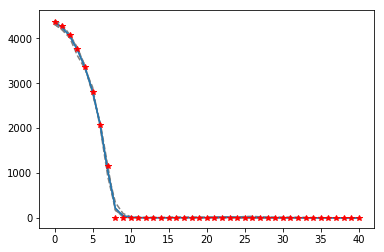

In [131]:
pos = 100
for i in range(5):
    plt.plot(models_sensi[i].predict(data_plain_train_sc[pos:pos+1,:,:])[0], color = 'grey', linestyle = '--')
plt.plot(ensemble_sensi.predict(data_plain_train_sc[pos:pos+1,:,:])[0])
plt.plot(targets_train[pos,:], 'r*')

In [194]:
# check results
count = 2
if os.path.isfile(wd_sensis +r'\setting_{}'.format(count)+r'\results.pkl'):
    with open(wd_sensis +r'\setting_{}'.format(count)+r'\results.pkl', 'rb') as input:
                cache = pickle.load(input)
print(cache[2],cache[3],cache[4],cache[5])           
cache[1]

0.05 0.02 2.7000000000000004e-08 1.2


,0.001,0.005,0.01,0.2,0.4,0.6,0.8,0.9,1
PV,776.52,3882.61,7765.21,155304.21,310608.43,465912.64,621216.86,6.99e+05,7.77e+05
[%],0.37,0.17,0.08,0.28,0.05,0.03,0.02,6.23e-03,3.77e-03
